Testing mlflow and pytorch

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

/home/studio-lab-user/.conda/envs/PRUEBA/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#train and test data directory
train_dir = "data_split/train"
test_dir = "data_split/test"
val_dir = "data_split/val"


#load the train, val and test data
train_data = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((128,128)),transforms.ToTensor()
]))

val_data = ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((128,128)),transforms.ToTensor()
]))

test_data = ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((128,128)),transforms.ToTensor()
]))

In [3]:
img, label = train_data[0]
print(img.shape,label)


torch.Size([3, 128, 128]) 0


In [4]:
print("Follwing classes are there : \n",train_data.classes)

Follwing classes are there : 
 ['gamma', 'iron', 'proton']


Label : gamma


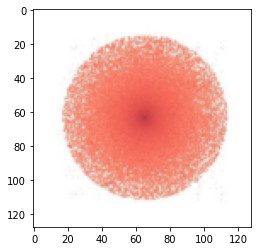

In [5]:
import matplotlib.pyplot as plt
def display_img(img,label):
    print(f"Label : {train_data.classes[label]}")
    plt.imshow(img.permute(1,2,0)) #permute method reshapes the image from (3,150,150) to (150,150,3)

#display the first image in the dataset
display_img(*train_data[0])

The data is divided into batches using the PyTorch DataLoader class. We create two objects train_dl and val_dl for training and validation data respectively by giving parameters training data and batch size into the DataLoader Class.

In [6]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")


#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 5121
Length of Validation Data : 640


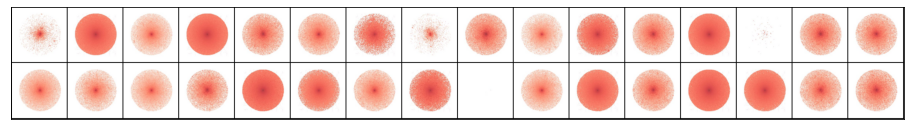

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [8]:

import os

import mlflow

mlflow.set_tracking_uri("https://dagshub.com/andreasorroche/TFM.mlflow")

os.environ["MLFLOW_TRACKING_USERNAME"] = "andreasorroche"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "repomlflow"


In [9]:
import os

import pytorch_lightning as pl
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

try:
    from torchmetrics.functional import accuracy
except ImportError:
    from pytorch_lightning.metrics.functional import accuracy

import mlflow.pytorch
from mlflow.tracking import MlflowClient

class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


    def training_step(self, batch, batch_nb):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        pred = logits.argmax(dim=1)
        acc = accuracy(pred, y)

        # Use the current of PyTorch logger
        self.log("train_loss", loss, on_epoch=True)
        self.log("acc", acc, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

def print_auto_logged_info(r):

    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))


model = Model()

# Initialize a trainer
trainer = pl.Trainer(max_epochs=3, progress_bar_refresh_rate=20)

# Auto log all MLflow entities
mlflow.pytorch.autolog()

# Train the model
with mlflow.start_run() as run:
    trainer.fit(model, train_dl)

# fetch the auto logged parameters and metrics
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

/home/studio-lab-user/.conda/envs/PRUEBA/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 1.7 K 
4 | fc2   | Linear    | 5.0 K 
5 | fc3   | Linear    | 153   
------------------------------------
9.8 K     Trainable params
0         Non-trainable

Epoch 2: 100%|██████████| 161/161 [00:08<00:00, 18.66it/s, loss=1.05, v_num=4]


2022/07/10 10:12:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/studio-lab-user/.conda/envs/PRUEBA/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


run_id: 6c154e6571d64e67b174d39a8695f5ef
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'epochs': '3', 'optimizer_name': 'Adam', 'lr': '0.02', 'betas': '(0.9, 0.999)', 'eps': '1e-08', 'weight_decay': '0', 'amsgrad': 'False', 'maximize': 'False', 'foreach': 'None', 'capturable': 'False'}
metrics: {'train_loss_step': 0.831849753856659, 'acc': 0.409490346908569, 'acc_step': 1.0, 'train_loss_epoch': 1.07314658164978, 'acc_epoch': 0.409490346908569, 'train_loss': 1.07314658164978}
tags: {'Mode': 'training'}
